# MODEL RSAa -- Conditional Trials Across Sets

#### Representational dissimilarity between correct and incorrect trials
#### Contains only conditional trials without preceding BLs
#### Combines A & C trials into single regressor
#### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

## Compares activation for regions of interest using binarized masks:
#### Hippocampus (FS labels: hippocampus [17,53])
#### Medial PFC (FS labels: caudal anterior cingulate, rostral anterior cingulate)
#### Dorsal Caudate (hand-drawn by Mandy)
#### Putamen (FS labels: putamen [12,51])
#### Ventral Visual Area (FS labels: fusiform, lingual,  parahippocampal [1007,2007,1013,2013,1016,2016])
#### Dorsolateral PFC (FS labels: caudal middle frontal, lateral orbital frontal, rostral middle frontal [1003,2003,1012,2012,1027,2027])
#### Pars Triangularis (FS labels: triangularis [1020,2020])

In [1]:
import os
import re
from os.path import join
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')
sns.set_style("white")

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_files = []
cope_files = []

for i, SID in enumerate(sids):
    mask_files_glob = glob(proj_dir + 'derivatives/roi_masks/hamm/anat_masks/_subject_id_' +SID+ '/_anatmask_xfm*/*')
    mask_files.append(sorted(mask_files_glob))
    rsc_files_glob = glob(proj_dir + 'derivatives/roi_masks/rsc_inepi/' +SID+ '/rsc_temp2epi/_subject_id_' +SID+ '/_targ2EPI*/*')
    mask_files[i].append(rsc_files_glob[0])
    subjcopes_glob = glob(proj_dir + 'Hamm_Learning/RSA1/lvl1/cond/' +SID+
                          '/modelfit/contrasts/_estimate_model*/cope??_B*')
    cope_files.append(sorted(subjcopes_glob))
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 12:
        print(SID, len(cope_files[-1]))

WMAZE_002 10
WMAZE_005 11
WMAZE_006 11
WMAZE_007 11
WMAZE_020 11
WMAZE_023 10


## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7]) 

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped
28 CCOPY_T_wmaze_template_trans


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-2][-1], cope_files[0][i].split('/')[-1][7:-7]) 

0 0 B_corr
1 0 B_incorr
2 1 B_corr
3 1 B_incorr
4 2 B_corr
5 2 B_incorr
6 3 B_corr
7 3 B_incorr
8 4 B_corr
9 4 B_incorr
10 5 B_corr
11 5 B_incorr


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [5]:
all_data = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc', 'parsT']:
    all_data['{0}'.format(r)] = {'run1_corr':[], 'run1_incorr':[], 'run2_corr':[], 'run2_incorr':[], #set1
                                 'run3_corr':[], 'run3_incorr':[], 'run4_corr':[], 'run4_incorr':[], #set2
                                 'run5_corr':[], 'run5_incorr':[], 'run6_corr':[], 'run6_incorr':[]} #set3
for i in range(len(sids)):
    lh_hp_img = nb.load(mask_files[i][3])
    rh_hp_img = nb.load(mask_files[i][16])
    lh_mpfc_img = nb.load(mask_files[i][5])
    rh_mpfc_img = nb.load(mask_files[i][18])
    lh_caud_img = nb.load(mask_files[i][9])
    rh_caud_img = nb.load(mask_files[i][12])
    lh_put_img = nb.load(mask_files[i][24])
    rh_put_img = nb.load(mask_files[i][27])
    lh_dlpfc_img = nb.load(mask_files[i][1])
    rh_dlpfc_img = nb.load(mask_files[i][14])
    lh_vocc_img = nb.load(mask_files[i][11])
    rh_vocc_img = nb.load(mask_files[i][23])
    lh_parsT_img = nb.load(mask_files[i][8])
    rh_parsT_img = nb.load(mask_files[i][21])
    bi_rsc_img = nb.load(mask_files[i][28])
    
    run1_corr_img = None
    run1_incorr_img = None
    run2_corr_img = None
    run2_incorr_img = None
    run3_corr_img = None
    run3_incorr_img = None
    run4_corr_img = None
    run4_incorr_img = None
    run5_corr_img = None
    run5_incorr_img = None
    run6_corr_img = None
    run6_incorr_img = None
    
    print(shape(lh_hp_img))
    
    set1 = [x for x in cope_files[i] if 'model0' in x or 'model1' in x] #grab if files exist for run1/2
    set2 = [x for x in cope_files[i] if 'model2' in x or 'model3' in x] 
    set3 = [x for x in cope_files[i] if 'model4' in x or 'model5' in x]
    
    for j, frst_run in enumerate(range(1,6,2)): #loads data for each set          
        if len(eval('set{0}'.format(j+1))) != 4: #if there are not 4 files (missing corr/incorr for one of the 2 runs)
            for key in ["hp","mpfc","caud","put","dlpfc","vocc","rsc","parsT"]:
                for acc in ["corr", "incorr"]: #append nan to all four keys                     
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run,acc)].append("nan")
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run+1,acc)].append("nan")
        else: #if all corr/incorr files exist for both runs
            exec('run{0}_corr_img = nb.load(set{1}[0])'.format(frst_run,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[1])'.format(frst_run,j+1))
            exec('run{0}_corr_img = nb.load(set{1}[2])'.format(frst_run+1,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[3])'.format(frst_run+1,j+1))    
            
    for key in ['hp', 'caud']: #combines masked hemisphere regions, appends to dict
        for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
            for acc in ['corr', 'incorr']: 
                if eval('{0}_{1}_img'.format(run,acc)) == None: #if run/acc mask does not exist, skip
                    continue
                else:
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    bihemi_data = np.concatenate((lh_data, rh_data)) 
                    all_data['{0}'.format(key)]['{0}_{1}'.format(run,acc)].append(bihemi_data)                    
    for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']: #appends masked rsc to dict
        for acc in ['corr', 'incorr']:
            if eval('{0}_{1}_img'.format(run,acc)) == None:
                continue
            else:
                bihemi_data = eval('{0}_{1}_img.get_data()[bi_rsc_img.get_data()[:,:,:,0] > 0.]'.format(run,acc))
                all_data['rsc']['{0}_{1}'.format(run,acc)].append(bihemi_data)  
                
for key in all_data: #creates individual region dfs
    exec('{0}_df = pd.DataFrame(all_data["{0}"])'.format(key))
all_data_df = pd.DataFrame(all_data) #turns dict to Panda's DF   

NameError: name 'shape' is not defined

In [5]:
all_corrs = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc', 'parsT']:
    all_corrs['{0}'.format(r)] = {'s1r1':[], 's1r2':[], 's2r1':[], 's2r2':[], 's3r1':[], 's3r2':[]}

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

for x, SID in enumerate(sids):
    for key in all_data:
        for i, frst_run in enumerate(range(1,6,2)):
            if type(eval('{0}_df["run{1}_corr"][x]'.format(key,i*2+1))) is str or type(eval('{0}_df["run{1}_corr"][x]'.format(key,i*2+2))) is str:
                exec('all_corrs["{0}"]["s{1}r1"].append("nan")'.format(key,i+1))
                exec('all_corrs["{0}"]["s{1}r2"].append("nan")'.format(key,i+1))
            else:
                exec('all_corrs["{0}"]["s{1}r1"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+1))
                exec('all_corrs["{0}"]["s{1}r2"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+2))

all_corrs_df = pd.DataFrame(all_corrs)

In [6]:
##Creates separate regional dataframes for investigating averaged EARLY vs LATE effects

split_runs = {}
for key in all_corrs_df.columns:
    split_runs[key] = {'early':[],'late':[]}
    for PID in range(len(sids)):
        early_runs = np.array([all_corrs_df[key][i][PID] for i, row in enumerate(all_corrs_df.index) if "r1" in row],
                              dtype=np.float64)
        late_runs =  np.array([all_corrs_df[key][i][PID] for i, row in enumerate(all_corrs_df.index) if "r2" in row],
                              dtype=np.float64)
        early_avg = np.nanmean(early_runs)
        late_avg = np.nanmean(late_runs)
        split_runs[key]['early'].append(early_avg)
        split_runs[key]['late'].append(late_avg)

for key in all_corrs_df.columns:
    exec('{0}_split_df = pd.DataFrame(split_runs["{0}"])'.format(key))

In [7]:
hp_split_df

,early,late
0,0.697046,0.836336
1,0.633431,1.112549
2,0.518041,0.618448
3,0.549311,0.579780
4,0.855925,0.539523
5,0.377705,0.629399
6,0.680164,0.664751
7,0.452479,0.551339
8,0.514555,0.462608
9,0.510737,0.743487


### Performance Calculation

In [8]:
all_prop_corr = {'s1r1':[], 's1r2':[], 's2r1':[], 's2r2':[],'s3r1':[], 's3r2':[]}
stim_sets = ['1', '2', '3']

for SID in sids:
    sub_dir = '/home/data/madlab/Mattfeld_WMAZE/sourcedata/behav/{0}/'.format(SID)
    dir_file = sorted(glob(join(sub_dir,'{0}_wmazebl_2015*.txt'.format(SID))))   
    early_runs = []
    late_runs = []
    for i, curr_set in enumerate(stim_sets):
        run1 = pd.read_table(dir_file[i*2]) #create dataframe for text files to extract EVS
        run1 = run1[:-3] #removal of the last 3 trials to avoid scanner artifact
        run2 = pd.read_table(dir_file[i*2+1])
        run2 = run2[:-3]
     
        trialtype1 = run1['TrialType'].values
        correct1 = run1['Correct'].values
        trial_shift1 = trialtype1[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift1 = np.append(trial_shift1, -1)
        correct_shift1 = correct1[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift1 = np.append(correct_shift1, -1)        
        corr1 = np.where(((trial_shift1=='B') & (correct_shift1==1)) & (trialtype1!='BL'))[0]
        incorr1 = np.where(((trial_shift1=='B') & (correct_shift1==0)) & (trialtype1!='BL'))[0]
        curr_prop_corr1 = len(corr1)/float(len(corr1) + len(incorr1))
        
        trialtype2 = run2['TrialType'].values
        correct2 = run2['Correct'].values
        trial_shift2 = trialtype2[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift2 = np.append(trial_shift2, -1)
        correct_shift2 = correct2[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift2 = np.append(correct_shift2, -1)        
        corr2 = np.where(((trial_shift2=='B') & (correct_shift2==1)) & (trialtype2!='BL'))[0]
        incorr2 = np.where(((trial_shift2=='B') & (correct_shift2==0)) & (trialtype2!='BL'))[0]
        curr_prop_corr2 = len(corr2)/float(len(corr2) + len(incorr2))
        
        if curr_prop_corr1 == 1.0 or curr_prop_corr2 == 1.0 or curr_prop_corr1 == 0.0 or curr_prop_corr2 == 0.0:
            all_prop_corr['s{0}r1'.format(curr_set)].append('nan')
            all_prop_corr['s{0}r2'.format(curr_set)].append('nan')     
        else:
            all_prop_corr['s{0}r1'.format(curr_set)].append(curr_prop_corr1)
            all_prop_corr['s{0}r2'.format(curr_set)].append(curr_prop_corr2)
            
all_prop_corr_df = pd.DataFrame(all_prop_corr)

In [9]:
all_prop_corr_df

,s1r1,s1r2,s2r1,s2r2,s3r1,s3r2
0,0.52,0.931034,0.92,0.888889,0.9,0.935484
1,nan,nan,nan,nan,0.939394,0.964286
2,0.821429,0.96,0.71875,0.84,0.774194,0.931034
3,0.636364,0.733333,nan,nan,0.806452,0.925926
4,0.481481,0.689655,nan,nan,0.866667,0.9375
5,0.518519,0.8,0.709677,0.793103,nan,nan
6,0.571429,0.777778,0.862069,0.966667,0.730769,0.967742
7,0.72,0.724138,0.76,0.827586,0.766667,0.939394
8,0.416667,0.592593,0.5,0.777778,0.677419,0.5
9,0.52,0.703704,0.814815,0.806452,0.8,0.903226


In [10]:
perf_split = {'early':[],'late':[]}

for SID in range(len(sids)): 
    early_runs = np.array([all_prop_corr_df['s1r1'][SID], all_prop_corr_df['s2r1'][SID], all_prop_corr_df['s3r1'][SID]], 
                          dtype=np.float64)
    late_runs = np.array([all_prop_corr_df['s1r2'][SID], all_prop_corr_df['s2r2'][SID], all_prop_corr_df['s3r2'][SID]], 
                         dtype=np.float64)
    early_avg = np.nanmean(early_runs)
    late_avg = np.nanmean(late_runs)
    perf_split['early'].append(early_avg)
    perf_split['late'].append(late_avg)

perf_split_df = pd.DataFrame(perf_split)

In [11]:
perf_split_df

,early,late
0,0.780000,0.918469
1,0.939394,0.964286
2,0.771457,0.910345
3,0.721408,0.829630
4,0.674074,0.813578
5,0.614098,0.796552
6,0.721422,0.904062
7,0.748889,0.830373
8,0.531362,0.623457
9,0.711605,0.804460


# Hippocampus

### Across Stimulus Set

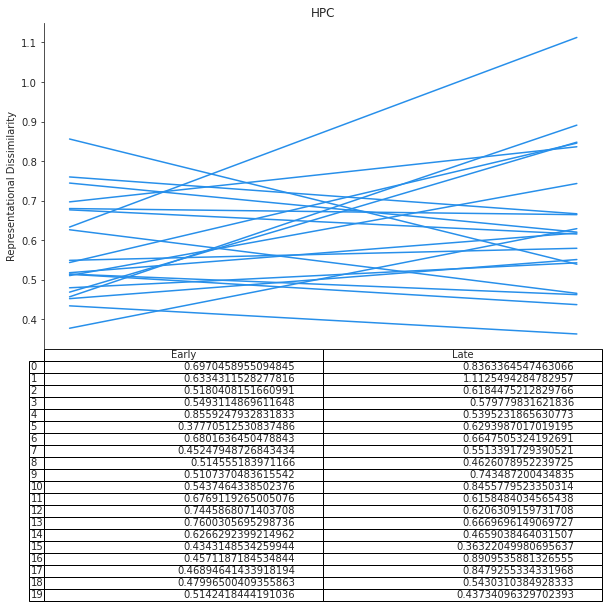

In [12]:
figure = {}
figure['Early'] = hp_split_df['early']
figure['Late'] = hp_split_df['late']
figure = pd.DataFrame(figure)
df1 = pd.DataFrame(figure.T)
conditions = ['Early', 'Late']
fig, ax = plt.subplots(figsize=(10,6), sharex=False, sharey=True)
sns.despine(top=True)
ax.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax, legend=False, color='#278fea')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_ylim(-0.2,0.8)
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('HPC')
plt.show()

Dissimilarity
Mean early:  0.5747943222689469
STD early:  0.12421635480641183

Mean late:  0.6517811140824536
STD late:  0.17770393813785468

Early vs. Late Learning
t-test (1.6152586207317634, 0.12273872502146553)
Cohen's d =  0.6921820306102545


<ipython-input-13-2e44b0aebd76>:13: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False,


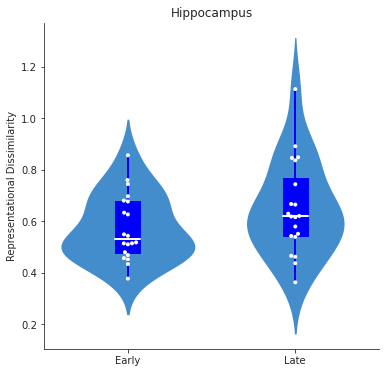

In [13]:
print('Dissimilarity')
for key in hp_split_df.columns:
    print('Mean {0}: '.format(key), np.mean(hp_split_df['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(hp_split_df['{0}'.format(key)]))
    print('')
N = 2
conditions = ['Early', 'Late']
allsubjs = [hp_split_df['early'], hp_split_df['late']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
           boxprops=dict(color='blue', facecolor='blue'),
           whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(-0.2,0.8)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Hippocampus')
print('Early vs. Late Learning')
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(hp_split_df['early'])[1] < 0.049 or stats.shapiro(hp_split_df['late'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(hp_split_df['late'], hp_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(hp_split_df['late'], hp_split_df['early'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(hp_split_df['late'], hp_split_df['early'])[:])
else: #normal distributions
    if stats.ttest_rel(hp_split_df['late'], hp_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(hp_split_df['late'], hp_split_df['early'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(hp_split_df['late'], hp_split_df['early'])[:])   
cohens_d = ((np.average(hp_split_df['late'])-np.average(hp_split_df['early'])) 
            /(sqrt((np.std(hp_split_df['late'],ddof=1))**2+np.std(hp_split_df['early'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/RSAa_F_hpc1.png", dpi=1000)
plt.show() 

Hippocampus
Early: (0.2628296222963763, 0.2629047991555422)
Late: (0.6651869374375456, 0.0013723419015469257) <---- **


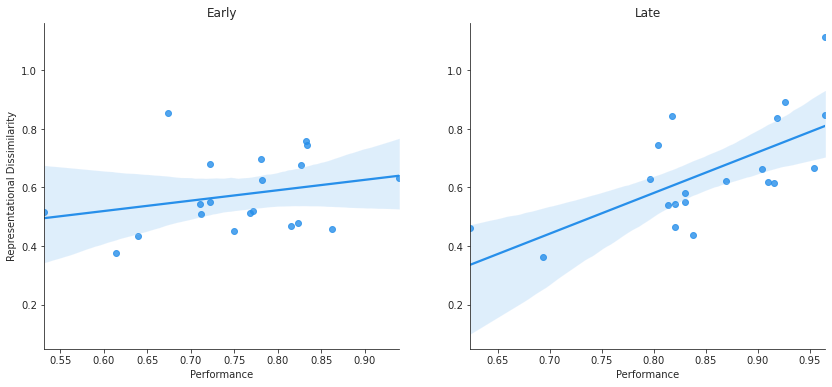

In [14]:
early_plot = {}
early_plot['brain'] = hp_split_df['early']
early_plot['behavior'] = perf_split_df['early']
early_plot = pd.DataFrame(early_plot)
late_plot = {}
late_plot['brain'] = hp_split_df['late']
late_plot['behavior'] = perf_split_df['late']
late_plot = pd.DataFrame(late_plot)
print('Hippocampus')
if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.025: #correction for multi comparisons       
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
else:
    print("Early:", pearsonr(early_plot['brain'], early_plot['behavior'])[:])
if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.025:        
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
else:
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#278fea', ax=ax1)
sns.despine(top=True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Representational Dissimilarity')
ax1.set_xlabel('Performance')
ax1.set_title('Early')
#ax1.set_ylim(-0.2,0.8)
ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#278fea', ax=ax2)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('Performance')
ax2.set_ylabel('')
ax2.set_title('Late')
#ax2.set_xlim(0.6,1)
#plt.savefig('/home/arenf001/figs/RSAa_C_hpc2.png', dpi=1000)
plt.show()

# Caudate

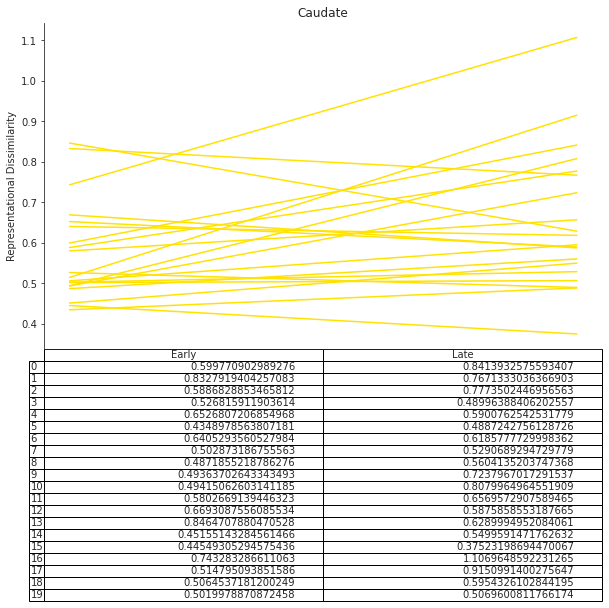

In [15]:
figure = {}
figure['Early'] = caud_split_df['early']
figure['Late'] = caud_split_df['late']
figure = pd.DataFrame(figure)
df1 = pd.DataFrame(figure.T)
conditions = ['Early', 'Late']
fig, ax = plt.subplots(figsize=(10,6), sharex=False, sharey=True)
sns.despine(top=True)
ax.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax, legend=False, color='#ffe200')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Caudate')
plt.show()

Dissimilarity
Mean early:  0.5756818431972379
STD early:  0.11878526693455192

Mean late:  0.6558842553485233
STD late:  0.1684575259253479

Early vs. Late Learning
Wilcoxon (53.0, 0.05316925048828125)
Cohen's d =  0.7584844987519825


<ipython-input-16-fe9647032f7e>:13: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


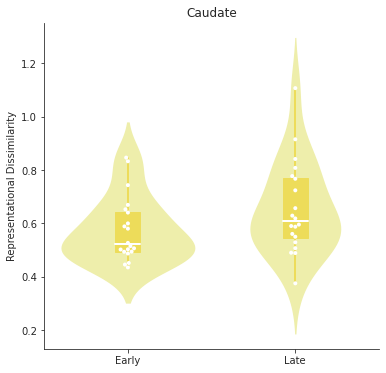

In [16]:
print('Dissimilarity')
for key in caud_split_df.columns:
    print('Mean {0}: '.format(key), np.mean(caud_split_df['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(caud_split_df['{0}'.format(key)]))
    print('')
N = 2
conditions = ['Early', 'Late']
allsubjs = [caud_split_df['early'], caud_split_df['late']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
           whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Caudate')
#ax.set_ylim(-0.4,1)
print('Early vs. Late Learning')
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(caud_split_df['early'])[1] < 0.049 or stats.shapiro(caud_split_df['late'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(caud_split_df['late'], caud_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(caud_split_df['late'], caud_split_df['early'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(caud_split_df['late'], caud_split_df['early'])[:])
else: #normal distributions
    if stats.ttest_rel(caud_split_df['late'], caud_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(caud_split_df['late'], caud_split_df['early'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(caud_split_df['late'], caud_split_df['early'])[:])        
cohens_d = ((np.average(caud_split_df['late'])-np.average(caud_split_df['early'])) 
            /(sqrt((np.std(caud_split_df['late'],ddof=1))**2+np.std(caud_split_df['early'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig('/home/arenf001/figs/RSAa_C_caud1.png', dpi=1000)
plt.show() 

Caudate
Early: (0.6308865663397503, 0.0028579186893357787) <---- **
Late: (0.6014146469149211, 0.00503139469028237) <---- **


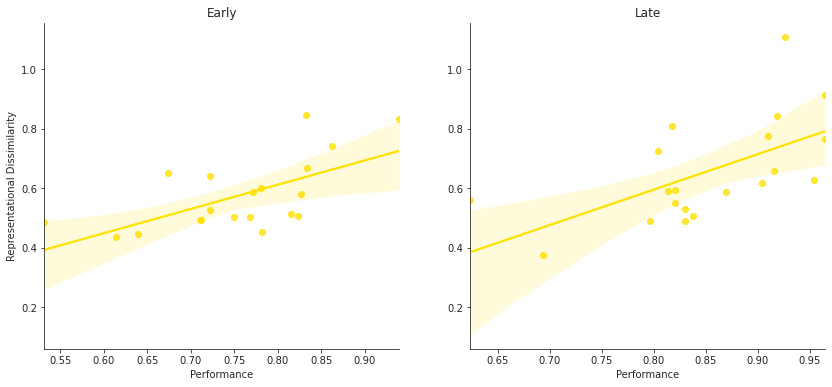

In [17]:
early_plot = {}
early_plot['brain'] = caud_split_df['early']
early_plot['behavior'] = perf_split_df['early']
early_plot = pd.DataFrame(early_plot)
late_plot = {}
late_plot['brain'] = caud_split_df['late']
late_plot['behavior'] = perf_split_df['late']
late_plot = pd.DataFrame(late_plot)
print('Caudate')
if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.025: #correction for multi comparisons       
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
else:
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.025:        
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
else:
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#ffe200', ax=ax1)
sns.despine(top=True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Representational Dissimilarity')
ax1.set_xlabel('Performance')
ax1.set_title('Early')
#ax1.set_ylim(-0.4,1)
ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#ffe200', ax=ax2)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('Performance')
ax2.set_ylabel('')
ax2.set_title('Late')
#ax2.set_xlim(0.6,1)
#plt.savefig('/home/arenf001/figs/RSAa_C_caud2.png', dpi=1000)
plt.show()

## Medial PFC

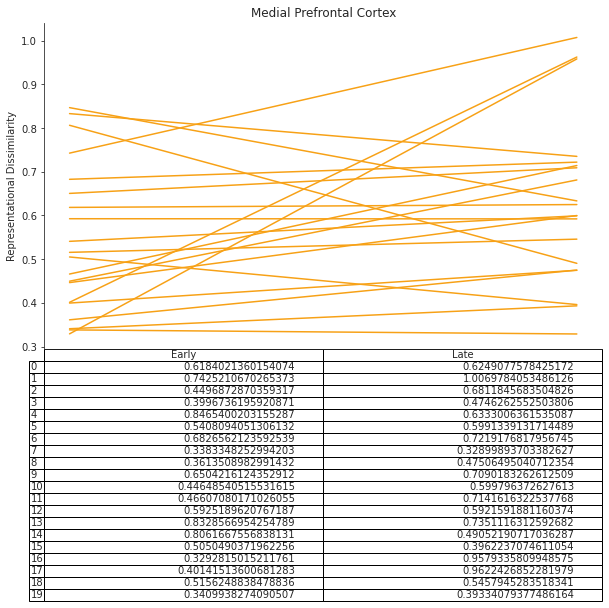

In [18]:
figure = {}
figure['Early'] = mpfc_split_df['early']
figure['Late'] = mpfc_split_df['late']
figure = pd.DataFrame(figure)
df1 = pd.DataFrame(figure.T)
conditions = ['Early', 'Late']
fig, ax = plt.subplots(figsize=(10,6), sharex=False, sharey=True)
sns.despine(top=True)
ax.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax, legend=False, color='#f7a116')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Medial Prefrontal Cortex')
plt.show()

Dissimilarity
Mean early:  0.5433430044770974
STD early:  0.16620579261245277

Mean late:  0.6321208729426371
STD late:  0.18366784072619707

Early vs. Late Learning
t-test (1.7682314856907346, 0.093076300352387)
Cohen's d =  0.6986506390140902


<ipython-input-19-7612a7af444a>:13: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


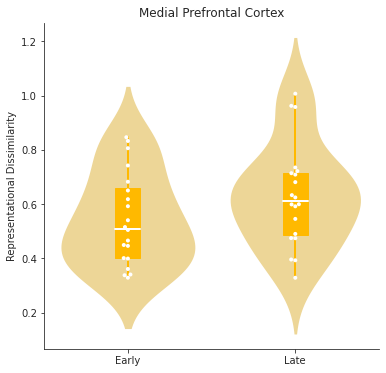

In [19]:
print('Dissimilarity')
for key in mpfc_split_df.columns:
    print('Mean {0}: '.format(key), np.mean(mpfc_split_df['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(mpfc_split_df['{0}'.format(key)]))
    print('')
N = 2
conditions = ['Early', 'Late']
allsubjs = [mpfc_split_df['early'], mpfc_split_df['late']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
           whiskerprops=dict(color='#ffb900', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Medial Prefrontal Cortex')
print('Early vs. Late Learning')
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(mpfc_split_df['early'])[1] < 0.049 or stats.shapiro(mpfc_split_df['late'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(mpfc_split_df['late'], mpfc_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(mpfc_split_df['late'], mpfc_split_df['early'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(mpfc_split_df['late'], mpfc_split_df['early'])[:])
else: #normal distributions
    if stats.ttest_rel(mpfc_split_df['late'], mpfc_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(mpfc_split_df['late'], mpfc_split_df['early'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(mpfc_split_df['late'], mpfc_split_df['early'])[:])        
cohens_d = ((np.average(mpfc_split_df['late'])-np.average(mpfc_split_df['early'])) 
            /(sqrt((np.std(mpfc_split_df['late'],ddof=1))**2+np.std(mpfc_split_df['early'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig("/home/arenf001/figs/RSAa_C_mpfc1.png", dpi=1000)
plt.show() 

Medial Prefrontal Cortex
Early: (0.1666696315068748, 0.4824846688437829)
Late: (0.7004653822638471, 0.0005829834490698201) <---- **


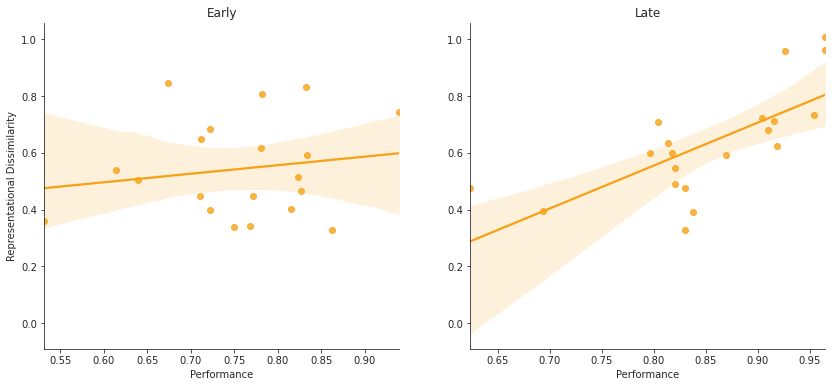

In [20]:
early_plot = {}
early_plot['brain'] = mpfc_split_df['early']
early_plot['behavior'] = perf_split_df['early']
early_plot = pd.DataFrame(early_plot)
late_plot = {}
late_plot['brain'] = mpfc_split_df['late']
late_plot['behavior'] = perf_split_df['late']
late_plot = pd.DataFrame(late_plot)
print('Medial Prefrontal Cortex')
if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.025: #correction for multi comparisons       
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
else:
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.025:        
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
else:
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#f7a116', ax=ax1)
sns.despine(top=True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Representational Dissimilarity')
ax1.set_xlabel('Performance')
ax1.set_title('Early')
#ax1.set_ylim(-0.2,1)
ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#f7a116', ax=ax2)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('Performance')
ax2.set_ylabel('')
ax2.set_title('Late')
#ax2.set_xlim(0.6,1)
#plt.savefig("/home/arenf001/figs/RSAa_C_mpfc2.png", dpi=1000)
plt.show()

## Putamen

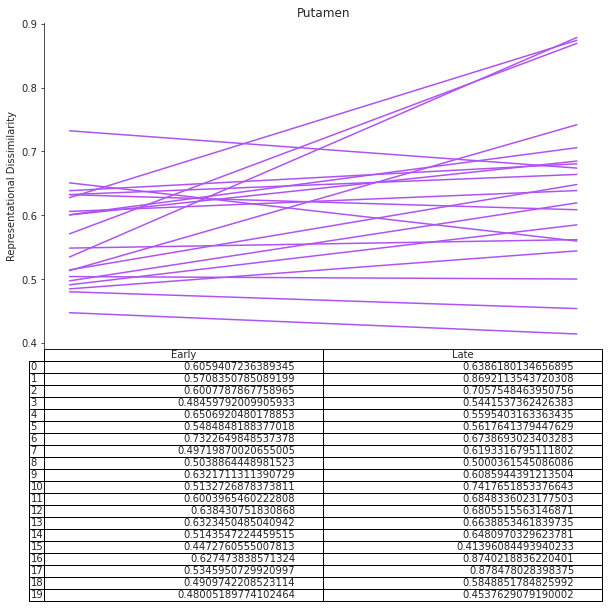

In [21]:
figure = {}
figure['Early'] = put_split_df['early']
figure['Late'] = put_split_df['late']
figure = pd.DataFrame(figure)
df1 = pd.DataFrame(figure.T)
conditions = ['Early', 'Late']
fig, ax = plt.subplots(figsize=(10,6), sharex=False, sharey=True)
sns.despine(top=True)
ax.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax, legend=False, color='#af52f4')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Putamen')
plt.show()

Dissimilarity
Mean early:  0.5653010739637013
STD early:  0.0726958251446939

Mean late:  0.6452557773357939
STD late:  0.12556729654256424



<ipython-input-23-d5d3be11a9f7>:13: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Early vs. Late Learning
t-test (2.9783957158365983, 0.0077221423652116305) <---- **
Cohen's d =  1.0742142231236103


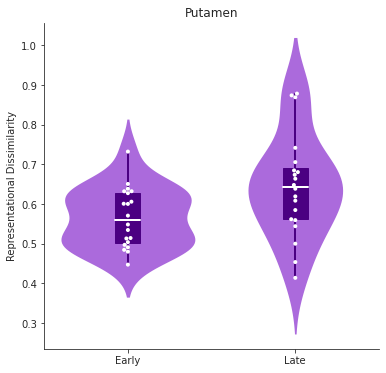

In [23]:
print('Dissimilarity')
for key in put_split_df.columns:
    print('Mean {0}: '.format(key), np.mean(put_split_df['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(put_split_df['{0}'.format(key)]))
    print('')
N = 2
conditions = ['Early', 'Late']
allsubjs = [put_split_df['early'], put_split_df['late']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
           whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Putamen')
#ax.set_ylim(-0.2,0.8)
print('Early vs. Late Learning')
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(put_split_df['early'])[1] < 0.049 or stats.shapiro(put_split_df['late'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(put_split_df['late'], put_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(put_split_df['late'], put_split_df['early'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(put_split_df['late'], put_split_df['early'])[:])
else: #normal distributions
    if stats.ttest_rel(put_split_df['late'], put_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(put_split_df['late'], put_split_df['early'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(put_split_df['late'], put_split_df['early'])[:])       
cohens_d = ((np.average(put_split_df['late'])-np.average(put_split_df['early'])) 
            /(sqrt((np.std(put_split_df['late'],ddof=1))**2+np.std(put_split_df['early'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig("/home/arenf001/figs/RSAa_C_put1.png", dpi=1000)
plt.show() 

Putamen
Early1: (0.2480454369307046, 0.29167304517319836)
Late : (0.7565473180897005, 0.00011325692427314885) <---- **


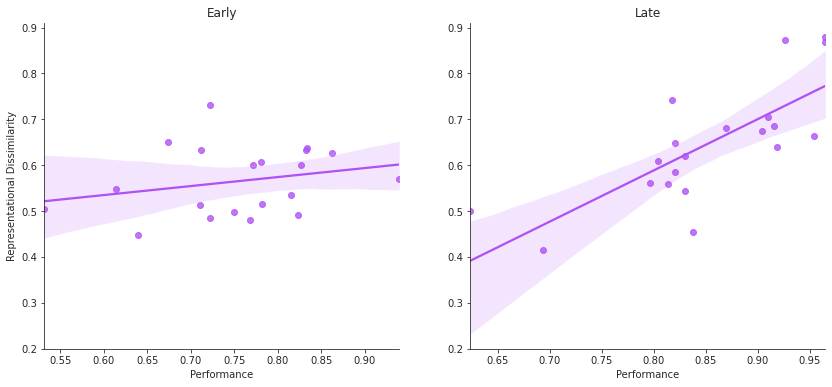

In [24]:
early_plot = {}
early_plot['brain'] = put_split_df['early']
early_plot['behavior'] = perf_split_df['early']
early_plot = pd.DataFrame(early_plot)
late_plot = {}
late_plot['brain'] = put_split_df['late']
late_plot['behavior'] = perf_split_df['late']
late_plot = pd.DataFrame(late_plot)
print('Putamen')
if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.025: #correction for multi comparisons       
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
else:
    print('Early1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.025:        
    print('Late :', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
else:
    print('Late:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#af52f4', ax=ax1)
sns.despine(top=True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Representational Dissimilarity')
ax1.set_xlabel('Performance')
ax1.set_title('Early')
#ax1.set_ylim(-0.2,0.8)
ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#af52f4', ax=ax2)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('Performance')
ax2.set_ylabel('')
ax2.set_title('Late')
#ax2.set_xlim(0.6,1)
#plt.savefig('/home/arenf001/figs/RSAa_C_put2.png', dpi=1000)
plt.show()

## Ventral Occipital

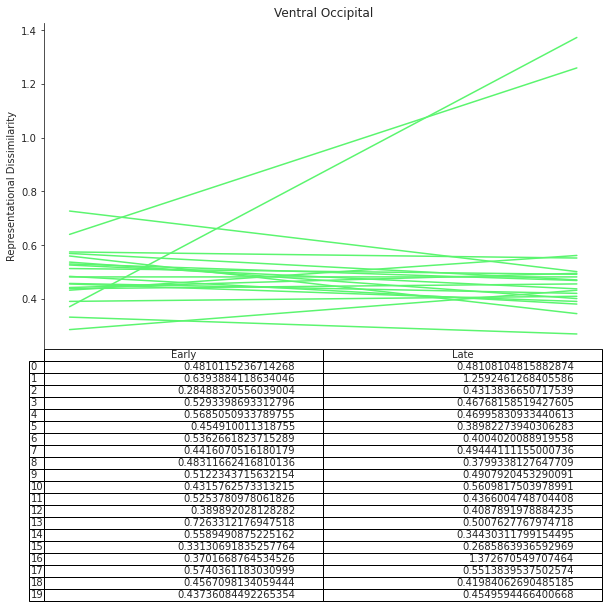

In [25]:
figure = {}
figure['Early'] = vocc_split_df['early']
figure['Late'] = vocc_split_df['late']
figure = pd.DataFrame(figure)
df1 = pd.DataFrame(figure.T)
conditions = ['Early', 'Late']
fig, ax = plt.subplots(figsize=(10,6), sharex=False, sharey=True)
sns.despine(top=True)
ax.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax, legend=False, color='#5bf56f')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Ventral Occipital')
plt.show()

Dissimilarity
Mean early:  0.48664848023829377
STD early:  0.1009925076906643

Mean late:  0.5291810370573173
STD late:  0.2710652981523611



<ipython-input-26-05b3d0b09da3>:13: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Early vs. Late Learning
Wilcoxon (82.0, 0.40909767150878906)
Cohen's d =  0.28662438674235907


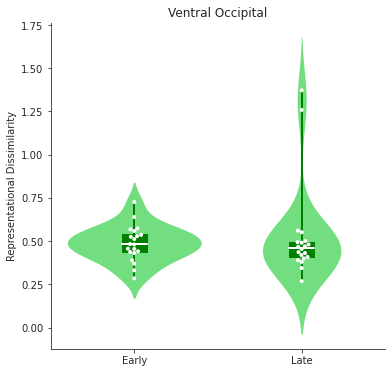

In [26]:
print('Dissimilarity')
for key in vocc_split_df.columns:
    print('Mean {0}: '.format(key), np.mean(vocc_split_df['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(vocc_split_df['{0}'.format(key)]))
    print('')
N = 2
conditions = ['Early', 'Late']
allsubjs = [vocc_split_df['early'], vocc_split_df['late']]
ind = np.arange(N)
fig,ax = plt.subplots(figsize=(6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#5bf56f', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='green', facecolor='green'),
           whiskerprops=dict(color='green', linewidth=2, linestyle = '-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('Representational Dissimilarity')
ax.set_title('Ventral Occipital')
print('Early vs. Late Learning')
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(vocc_split_df['early'])[1] < 0.049 or stats.shapiro(vocc_split_df['late'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(vocc_split_df['late'], vocc_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(vocc_split_df['late'], vocc_split_df['early'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(vocc_split_df['late'], vocc_split_df['early'])[:])
else: #normal distributions
    if stats.ttest_rel(vocc_split_df['late'], vocc_split_df['early'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(vocc_split_df['late'], vocc_split_df['early'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(vocc_split_df['late'], vocc_split_df['early'])[:])     
cohens_d = ((np.average(vocc_split_df['late'])-np.average(vocc_split_df['early'])) 
            /(sqrt((np.std(vocc_split_df['late'],ddof=1))**2+np.std(vocc_split_df['early'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig("/home/arenf001/figs/RSAa_C_vocc1.png", dpi=1000)
plt.show() 

Ventral Occipital
Early: (0.24544094824235088, 0.29693358588970986)
Late (0.47527113795361364, 0.03419143030755056)


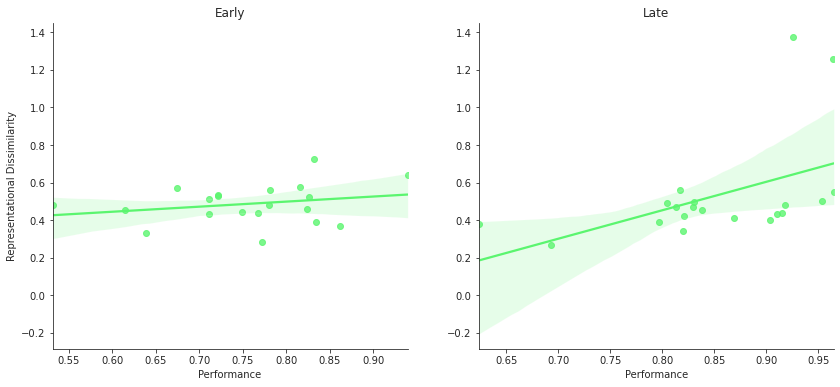

In [27]:
early_plot = {}
early_plot['brain'] = vocc_split_df['early']
early_plot['behavior'] = perf_split_df['early']
early_plot = pd.DataFrame(early_plot)
late_plot = {}
late_plot['brain'] = vocc_split_df['late']
late_plot['behavior'] = perf_split_df['late']
late_plot = pd.DataFrame(late_plot)
print('Ventral Occipital')
if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.025: #correction for multi comparisons       
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
else:
    print('Early:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.025:        
    print('Late', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
else:
    print('Late', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#5bf56f', ax=ax1)
sns.despine(top=True)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Representational Dissimilarity')
ax1.set_xlabel('Performance')
ax1.set_title('Early')
#ax1.set_ylim(-0.5,0.8)
ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#5bf56f', ax=ax2)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xlabel('Performance')
ax2.set_ylabel('')
ax2.set_title('Late')
#ax2.set_xlim(0.6,1)
#plt.savefig('/home/arenf001/figs/RSAa_C_vocc2.png', dpi=1000)
plt.show()